author: lukostudy
April 2023

### Process data:
### for Customers and Menus tables in the LittleLemonDB

The source of the data: 

xlsx file with 21k records of fictional orders provided for the Meta Database Engineer Capstone Project.  
This data should be used for Tableau analysis but it can be also a good set to fill in the LittleLemon transactional database.

What the notebook does?  

The data needs to be cleaned and processed before final loading into the DB - the job done by this notebook.
The notebook saves CSV files and optionally pushes the data to the database. 

**During the processing of the data it turned out that the data is not the best quality. It's just a buch of random records that don't make sense in many aspects. That's why significant part of data from the xlsx file was replaced by a generated set of data.**

Due the fact that the data turned out to be not valuable as it looked in the beginning, so this files is overkill but it works :)
The goal (data in the DB) could be achieved in much simpler way by generating the data.

In [1]:
import regex as re
import pandas as pd
import random as rand
import numpy as np
import datetime as dt

### Set the parameters

In [2]:
# percentage of records to select form data0
# 10% will load to the DB over 20k records in total which should take less than 1 minute
# 100% will load to the DB over 133k records in total which should take around 5 minutes
percentage_of_data0 = 10 #set a value from 1 to 100

# DB connection
db = {
  'host' : "127.0.0.1",
  'port' : 3306,
  'user' : "admin",
  'password' : "admin",
  'database' : "LittleLemonDB"
}

LittleLemon_data =  {   'file' : "data_LittleLemon.xlsx",
                        'sheet': "Orders"
                    }

countries_data_file = "./data_Countries.csv"

# Set to False if you want to load data to the DB step by step 
LOAD_DATA_AUTOMATICALLY = False # True / False


# set this variable If you want to store SQL INSERTS in a file
# provide a name of while where to write SQL INSERTS
# set None if you don't want the SQL INSERTS to be written to a file
#sql_inserts_file = None
sql_inserts_file = "./data_SQL_INSERTS.sql"

In [3]:
data0 = pd.read_excel(LittleLemon_data['file'], LittleLemon_data['sheet'])

In [4]:



data0_records_ids = list(range(len(data0)))
qty_to_select = int(percentage_of_data0/100 * len(data0))
selected_records = np.zeros(shape=(len(data0)),dtype=bool)

data0_records_ids

while qty_to_select > 0:
    selected_index = rand.choice(data0_records_ids)
    data0_records_ids.remove(selected_index)
    selected_records[selected_index] = True
    qty_to_select -= 1


data0_reduced = data0[selected_records]
print(f"Selected: {len(data0_reduced)} records")






Selected: 2100 records


# Menus

Let's select those interesting columns and change their names

In [5]:
# original_name : new_name
selected_menus_columns = {
      'Cuisine Name' : 'Cuisine',  
      'Starter Name' : 'Starter',
      'Course Name' : 'Course',
      'Sides' : 'Sides',
      'Desert Name' : 'Dessert',
      'Drink' : 'Drink',
      'Sales' : 'Sales',
      'Discount' : 'Discount',
      'Quantity' : 'Qty'
}

menus_df = data0_reduced.rename(columns = selected_menus_columns)[selected_menus_columns.values()]
menus_df

,Cuisine,Starter,Course,Sides,Dessert,Drink,Sales,Discount,Qty
5,Italian,Hummus,Shwarma,Fries,Baklava,Turkish Coffee,315.000,89.84,1
7,Turkish,Flatbread,Bean soup,Potato salad,Ice cream,Corfu Red Wine,337.500,91.41,3
9,Italian,Tomato bread,Carbonara,Focaccia,Affogato,Roma Red wine,147.000,80.34,1
45,Italian,Flatbread,Carbonara,Focaccia,Affogato,Roma Red wine,315.000,37.04,1
46,Italian,Minestrone,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,465.000,24.00,2
...,...,...,...,...,...,...,...,...,...
20948,Greek,Hummus,Greek salad,Tapas,Greek yoghurt,Athens White wine,285.000,35.44,2
20951,Turkish,Flatbread,Carbonara,Focaccia,Affogato,Roma Red wine,186.930,91.14,3
20956,Greek,Olives,Pizza,Bruschetta,Cheesecake,Italian Coffee,137.760,20.00,2
20987,Turkish,Olives,Carbonara,Focaccia,Affogato,Roma Red wine,330.000,20.00,3


Checking discounts values [%] in relation to Sales values ...

<AxesSubplot: ylabel='Frequency'>

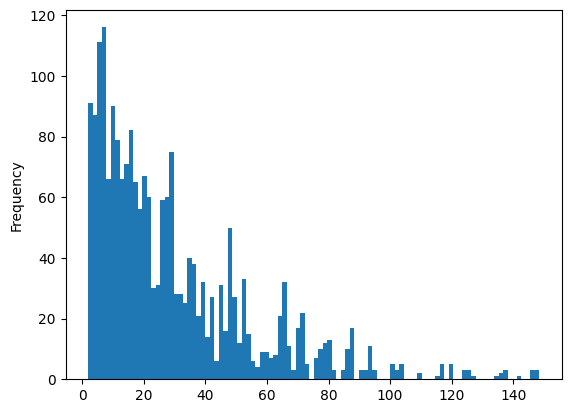

In [6]:
(menus_df["Discount"]/(menus_df["Sales"])*100).plot.hist(bins=100)

Values of Discount are very high in relation to Sales. Many cases even over 100% which does not make sense ... 

Conclusion and assumption:
Sales values are values after subtracting Discount values, so the list price of the mnenus are: Sales + Discount

Let's check how it looks like ...

discounts:   min: 1.9%   max: 59.7%


<AxesSubplot: ylabel='Frequency'>

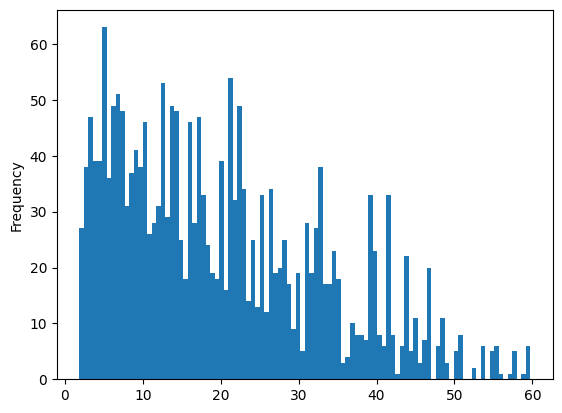

In [7]:
discounts_pct = (menus_df["Discount"]/(menus_df["Sales"]+menus_df["Discount"])*100)
print(f'discounts:   min: {discounts_pct.min():.1f}%   max: {discounts_pct.max():.1f}%')
discounts_pct.plot.hist(bins=100)

Now the discounts are in 2-60% range which is much more reasonable.
Conclusion and further assumption:
The prices for the menus will be set as (Sales+Discount)/Qty

In [8]:
menus_df["Price"] = (menus_df["Sales"]+menus_df["Discount"])/menus_df["Qty"]
menus_df

,Cuisine,Starter,Course,Sides,Dessert,Drink,Sales,Discount,Qty,Price
5,Italian,Hummus,Shwarma,Fries,Baklava,Turkish Coffee,315.000,89.84,1,404.840000
7,Turkish,Flatbread,Bean soup,Potato salad,Ice cream,Corfu Red Wine,337.500,91.41,3,142.970000
9,Italian,Tomato bread,Carbonara,Focaccia,Affogato,Roma Red wine,147.000,80.34,1,227.340000
45,Italian,Flatbread,Carbonara,Focaccia,Affogato,Roma Red wine,315.000,37.04,1,352.040000
46,Italian,Minestrone,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,465.000,24.00,2,244.500000
...,...,...,...,...,...,...,...,...,...,...
20948,Greek,Hummus,Greek salad,Tapas,Greek yoghurt,Athens White wine,285.000,35.44,2,160.220000
20951,Turkish,Flatbread,Carbonara,Focaccia,Affogato,Roma Red wine,186.930,91.14,3,92.690000
20956,Greek,Olives,Pizza,Bruschetta,Cheesecake,Italian Coffee,137.760,20.00,2,78.880000
20987,Turkish,Olives,Carbonara,Focaccia,Affogato,Roma Red wine,330.000,20.00,3,116.666667


Remove columns not needed anymore

In [9]:
menus_df_tmp = menus_df.drop(columns=['Sales', 'Discount', 'Qty'])

Let's check how the prices look like across the data for the same menus ...

In [10]:
menus_df_tmp_grp = menus_df_tmp.groupby(['Cuisine','Starter','Course','Sides','Dessert','Drink']).agg({'Price':['min','max','mean']})
menus_df_tmp_grp.rename(columns={'Price':'PriceAgg'}, inplace=True)
menus_df_tmp_grp

PriceAgg  \
                                                                                       min   
Cuisine Starter      Course      Sides        Dessert         Drink                          
Greek   Falafel      Greek salad Tapas        Greek yoghurt   Athens White wine  44.320000   
                     Kabasa      Meatballs    Turkish yoghurt Ankara White Wine  46.560000   
                     Pizza       Bruschetta   Cheesecake      Italian Coffee     49.060000   
        Flatbread    Greek salad Tapas        Greek yoghurt   Athens White wine  50.560000   
                     Kabasa      Meatballs    Turkish yoghurt Ankara White Wine  44.320000   
...                                                                                    ...   
Turkish Olives       Carbonara   Focaccia     Affogato        Roma Red wine      25.521667   
                     Shwarma     Fries        Baklava         Turkish Coffee     25.618333   
        Tomato bread Bean soup   Potato salad Ice cream       Corfu Red Wine     26.028333   
                     Carbonara   Focaccia     Affogato        Roma Red wine      26.028333   
                     Shwarma     Fries        Baklava         Turkish Coffee     26.028333   

                                                                                             \
                                                                                        max   
Cuisine Starter      Course      Sides        Dessert         Drink                           
Greek   Falafel      Greek salad Tapas        Greek yoghurt   Athens White wine  289.620000   
                     Kabasa      Meatballs    Turkish yoghurt Ankara White Wine  289.005000   
                     Pizza       Bruschetta   Cheesecake      Italian Coffee     289.620000   
        Flatbread    Greek salad Tapas        Greek yoghurt   Athens White wine  289.620000   
                     Kabasa      Meatballs    Turkish yoghurt Ankara White Wine  281.240000   
...                                                                                     ...   
Turkish Olives       Carbonara   Focaccia     Affogato        Roma Red wine      147.970000   
                     Shwarma     Fries        Baklava         Turkish Coffee     140.470000   
        Tomato bread Bean soup   Potato salad Ice cream       Corfu Red Wine     143.080000   
                     Carbonara   Focaccia     Affogato        Roma Red wine      144.086667   
                     Shwarma     Fries        Baklava         Turkish Coffee     144.086667   

                                                                                             
                                                                                       mean  
Cuisine Starter      Course      Sides        Dessert         Drink                          
Greek   Falafel      Greek salad Tapas        Greek yoghurt   Athens White wine  137.680000  
                     Kabasa      Meatballs    Turkish yoghurt Ankara White Wine  121.396875  
                     Pizza       Bruschetta   Cheesecake      Italian Coffee     136.984674  
        Flatbread    Greek salad Tapas        Greek yoghurt   Athens White wine  120.985595  
                     Kabasa      Meatballs    Turkish yoghurt Ankara White Wine  142.832500  
...                                                                                     ...  
Turkish Olives       Carbonara   Focaccia     Affogato        Roma Red wine       77.795590  
                     Shwarma     Fries        Baklava         Turkish Coffee      86.802135  
        Tomato bread Bean soup   Potato salad Ice cream       Corfu Red Wine      89.843036  
                     Carbonara   Focaccia     Affogato        Roma Red wine       94.665714  
                     Shwarma     Fries        Baklava         Turkish Coffee      81.984194  

[72 rows x 3 columns]

The prices vary significantly
We'll take mean of the prices as a price for menus

In [11]:
# converting columns names tuples to strings
print(menus_df_tmp_grp.columns)
menus_df_tmp_grp.columns = menus_df_tmp_grp.columns.map("".join)
print(menus_df_tmp_grp.columns)
# drop PriceAgg min and max
menus_df_tmp_grp.drop(columns=['PriceAggmin','PriceAggmax'], inplace=True)
# rename PriceAggmean -> Prirce
menus_df_tmp_grp.rename(columns={'PriceAggmean' :'Price'}, inplace=True)
# reset index -> move index records ito data frame as columns
menus_df_tmp_grp.reset_index(inplace=True)
menus_df_tmp_grp


MultiIndex([('PriceAgg',  'min'),
            ('PriceAgg',  'max'),
            ('PriceAgg', 'mean')],
           )
Index(['PriceAggmin', 'PriceAggmax', 'PriceAggmean'], dtype='object')


,Cuisine,Starter,Course,Sides,Dessert,Drink,Price
0,Greek,Falafel,Greek salad,Tapas,Greek yoghurt,Athens White wine,137.680000
1,Greek,Falafel,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,121.396875
2,Greek,Falafel,Pizza,Bruschetta,Cheesecake,Italian Coffee,136.984674
3,Greek,Flatbread,Greek salad,Tapas,Greek yoghurt,Athens White wine,120.985595
4,Greek,Flatbread,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,142.832500
...,...,...,...,...,...,...,...
67,Turkish,Olives,Carbonara,Focaccia,Affogato,Roma Red wine,77.795590
68,Turkish,Olives,Shwarma,Fries,Baklava,Turkish Coffee,86.802135
69,Turkish,Tomato bread,Bean soup,Potato salad,Ice cream,Corfu Red Wine,89.843036
70,Turkish,Tomato bread,Carbonara,Focaccia,Affogato,Roma Red wine,94.665714


Now we have a table with menus - almost ready to use in the database ...  
We are missing menus names yet ... Let's try to create it ...  
and prices should be rounded ...  

In [12]:
created_random_words = set() 


def random_word(letters, word_length=10, unique=True, retry = 5):
    # Let's create a random name out of all letters in the menu names
    global created_random_words

    if retry == 0: return None

    vovels = 'euioa'
    num_of_letters = len(letters)
    last_vovel = None
    rword = ""
    
    i = 0
    while len(rword) < word_length:
        x = letters[rand.randint(0,num_of_letters-1)]
        is_vovel = x in vovels
        #print(f">>> {x} is vovel? {is_vovel}")
        if last_vovel is None or (not last_vovel and is_vovel) or (last_vovel and not is_vovel):
            rword += x
        last_vovel = is_vovel
        i += 1
        if i>100: break
    #print(">>> rand iteration", i)
    if rword in created_random_words:
        print(f"{rword}  DUPLICATION!!! Trying again ...")
        # Let's try again
        return random_word(letters, word_length, unique, retry-1)
    else:
        created_random_words.add(rword)
        return rword


# Set length of random menus names here
NAME_LENGHT = 8


def f(record):
    list_of_words = [] 
    list_of_names = [name.strip().split() for name in record.tolist()]
    for name in list_of_names:
        list_of_words.extend(name)
    list_of_words = [word.lower() for word in list_of_words]
    joint_words = "".join(list_of_words)
    return(random_word(joint_words, word_length=NAME_LENGHT).capitalize())
        

# Let's add some random menu names ... hopefully none of them is offensive
menus_df_tmp_grp['Name'] = menus_df_tmp_grp[['Cuisine','Starter','Course','Sides','Dessert']].apply(f, axis=1)
print(len(created_random_words))
print(len(menus_df_tmp_grp))
menus_df_tmp_grp['Price'] = menus_df_tmp_grp['Price'].round(0)
menus_df_tmp_grp


72
72


,Cuisine,Starter,Course,Sides,Dessert,Drink,Price,Name
0,Greek,Falafel,Greek salad,Tapas,Greek yoghurt,Athens White wine,138.0,Epefarat
1,Greek,Falafel,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,121.0,Eratesut
2,Greek,Falafel,Pizza,Bruschetta,Cheesecake,Italian Coffee,137.0,Akafacak
3,Greek,Flatbread,Greek salad,Tapas,Greek yoghurt,Athens White wine,121.0,Habareke
4,Greek,Flatbread,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,143.0,Utekayab
...,...,...,...,...,...,...,...,...
67,Turkish,Olives,Carbonara,Focaccia,Affogato,Roma Red wine,78.0,Sacatava
68,Turkish,Olives,Shwarma,Fries,Baklava,Turkish Coffee,87.0,Herihala
69,Turkish,Tomato bread,Bean soup,Potato salad,Ice cream,Corfu Red Wine,90.0,Harokicu
70,Turkish,Tomato bread,Carbonara,Focaccia,Affogato,Roma Red wine,95.0,Fafaboto


In [13]:
ID_list = [id for id in range(1, len(menus_df_tmp_grp)+1)]
menus_df_tmp_grp["ID"] = [*range(1, len(menus_df_tmp_grp)+1)]
menus_df_tmp_grp

,Cuisine,Starter,Course,Sides,Dessert,Drink,Price,Name,ID
0,Greek,Falafel,Greek salad,Tapas,Greek yoghurt,Athens White wine,138.0,Epefarat,1
1,Greek,Falafel,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,121.0,Eratesut,2
2,Greek,Falafel,Pizza,Bruschetta,Cheesecake,Italian Coffee,137.0,Akafacak,3
3,Greek,Flatbread,Greek salad,Tapas,Greek yoghurt,Athens White wine,121.0,Habareke,4
4,Greek,Flatbread,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,143.0,Utekayab,5
...,...,...,...,...,...,...,...,...,...
67,Turkish,Olives,Carbonara,Focaccia,Affogato,Roma Red wine,78.0,Sacatava,68
68,Turkish,Olives,Shwarma,Fries,Baklava,Turkish Coffee,87.0,Herihala,69
69,Turkish,Tomato bread,Bean soup,Potato salad,Ice cream,Corfu Red Wine,90.0,Harokicu,70
70,Turkish,Tomato bread,Carbonara,Focaccia,Affogato,Roma Red wine,95.0,Fafaboto,71


In [14]:
menus_final_df = menus_df_tmp_grp[['ID', 'Name', 'Cuisine', 'Starter', 'Course', 'Sides', 'Dessert', 'Drink', 'Price']].copy(deep=True)
menus_final_df

,ID,Name,Cuisine,Starter,Course,Sides,Dessert,Drink,Price
0,1,Epefarat,Greek,Falafel,Greek salad,Tapas,Greek yoghurt,Athens White wine,138.0
1,2,Eratesut,Greek,Falafel,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,121.0
2,3,Akafacak,Greek,Falafel,Pizza,Bruschetta,Cheesecake,Italian Coffee,137.0
3,4,Habareke,Greek,Flatbread,Greek salad,Tapas,Greek yoghurt,Athens White wine,121.0
4,5,Utekayab,Greek,Flatbread,Kabasa,Meatballs,Turkish yoghurt,Ankara White Wine,143.0
...,...,...,...,...,...,...,...,...,...
67,68,Sacatava,Turkish,Olives,Carbonara,Focaccia,Affogato,Roma Red wine,78.0
68,69,Herihala,Turkish,Olives,Shwarma,Fries,Baklava,Turkish Coffee,87.0
69,70,Harokicu,Turkish,Tomato bread,Bean soup,Potato salad,Ice cream,Corfu Red Wine,90.0
70,71,Fafaboto,Turkish,Tomato bread,Carbonara,Focaccia,Affogato,Roma Red wine,95.0


It turned out that this data must be processes again ... due to the model change  

This must be split into Menus, MenuItems and Cuisines

In [15]:
cuisines_df = menus_final_df[['Cuisine']]
cuisines_df = cuisines_df.drop_duplicates()
cuisines_df.reset_index(drop=True, inplace=True)
cuisines_df['CuisineID'] = pd.Series(range(1,len(cuisines_df)+1))
cuisines_final_df = cuisines_df[['CuisineID','Cuisine']]
cuisines_final_df.rename(columns={'Cuisine':'Name'}, inplace=True)
cuisines_final_df

,CuisineID,Name
0,1,Greek
1,2,Italian
2,3,Turkish


In [16]:
menu_items = pd.DataFrame()
for item_cat in ['Starter', 'Course', 'Sides', 'Dessert','Drink']:
    menu_items = pd.concat([menu_items,menus_final_df[item_cat]],axis=0, ignore_index=True)
menu_items.rename(columns={0:"Name"}, inplace=True)
menu_items.drop_duplicates(inplace=True)
menu_items.reset_index(inplace=True, drop=True)
menu_items.reset_index(inplace=True)
menu_items.rename(columns={'index':'MenuItemID'}, inplace=True)
menu_items['MenuItemID'] = menu_items['MenuItemID'] +1

Let's add a price to each Item which will allow us to calculate menu Prices

In [17]:
prices = [20,15,12,22,10,14,25,27,29,19,24,26,17,30,16,22,10,12,9,9,19,17,15,12,20,24,6,25,25,6]
prices_df = pd.DataFrame(data=prices, columns=['Price'])
menu_items['Price'] = prices_df['Price']
menu_items_df = menu_items

In [18]:
menu_items_final_df = menu_items_df
menu_items_final_df

,MenuItemID,Name,Price
0,1,Falafel,20
1,2,Flatbread,15
2,3,Hummus,12
3,4,Minestrone,22
4,5,Olives,10
5,6,Tomato bread,14
6,7,Greek salad,25
7,8,Kabasa,27
8,9,Pizza,29
9,10,Bean soup,19


In [19]:
def menuitem_name_to_ID(name):
    return menu_items[menu_items['Name'] == name].iloc[0]['MenuItemID'].item()

def cuisine_name_to_ID(name):
    return cuisines_final_df[cuisines_final_df['Name'] == name].iloc[0]['CuisineID'].item()


for item_cat in ['Starter', 'Course', 'Sides', 'Dessert','Drink']:
    menus_final_df[item_cat+'ID'] = menus_final_df[item_cat].apply(menuitem_name_to_ID)

menus_final_df['CuisineID'] = menus_final_df['Cuisine'].apply(cuisine_name_to_ID)

print(menus_final_df)



    ID      Name  Cuisine       Starter       Course         Sides  \
0    1  Epefarat    Greek       Falafel  Greek salad         Tapas   
1    2  Eratesut    Greek       Falafel       Kabasa     Meatballs   
2    3  Akafacak    Greek       Falafel        Pizza    Bruschetta   
3    4  Habareke    Greek     Flatbread  Greek salad         Tapas   
4    5  Utekayab    Greek     Flatbread       Kabasa     Meatballs   
..  ..       ...      ...           ...          ...           ...   
67  68  Sacatava  Turkish        Olives    Carbonara      Focaccia   
68  69  Herihala  Turkish        Olives      Shwarma         Fries   
69  70  Harokicu  Turkish  Tomato bread    Bean soup  Potato salad   
70  71  Fafaboto  Turkish  Tomato bread    Carbonara      Focaccia   
71  72  Okabowab  Turkish  Tomato bread      Shwarma         Fries   

            Dessert              Drink  Price  StarterID  CourseID  SidesID  \
0     Greek yoghurt  Athens White wine  138.0          1         7       13   
1

One more change ... :(
    
Now instead of 5 columns like startr, course, .... we'll add SelectionCategory:  
1 - Starter
2 - Course
3 - Sides
4 - Dessert
5 - Drink

In [20]:
const_columns = ['ID']
list_of_converted_menus = []

for id, menu_sel_category in enumerate(['StarterID', 'CourseID', 'SidesID','DessertID', 'DrinkID'], start=1):
    cols = const_columns + [menu_sel_category]
    menus_one_sel_cat = menus_final_df.loc[:,cols]
    menus_one_sel_cat['MenuSelCatID'] = id
    menus_one_sel_cat.rename(columns={menu_sel_category : "MenuItemID"}, inplace=True)
    list_of_converted_menus.append(menus_one_sel_cat.copy(deep=True))


menus_selection_df = pd.concat(list_of_converted_menus)
menus_selection_df.reset_index(drop=True, inplace=True)

menus_selection_final_df = menus_selection_df.rename(columns={"ID":"MenuID"})


In [21]:
# finally we have menu_final_df converted into:
# 
cuisines_final_df
menu_items_final_df
menus_final_df
menus_selection_final_df
#

,MenuID,MenuItemID,MenuSelCatID
0,1,1,1
1,2,1,1
2,3,1,1
3,4,2,1
4,5,2,1
...,...,...,...
355,68,29,5
356,69,30,5
357,70,28,5
358,71,29,5


One more thing ... we need something more making sense as TotalCost value in the DB since the values in the datasheet are random without making any sense
Let's calculate a price for each Menu

In [22]:
menu_items_price_df = pd.merge(menus_selection_final_df, menu_items_final_df, on='MenuItemID')

def menu_price(menu_id):
    return menu_items_price_df[menu_items_price_df.loc[:,'MenuID'] == menu_id].loc[:,'Price'].sum().item()


Menus are DONE! :)

# Customers

Let's select columns related to customers and change columns' names

In [23]:
selected_customers_columns = {
      'Customer ID' : 'CustID',
      'Customer Name' : 'Name',
      'City' : 'City',
      'Country' : 'Country',
      'Postal Code' : 'PostCode',
      'Country Code' : 'CountryCode'
}

customers_df = data0_reduced.rename(columns = selected_customers_columns)[selected_customers_columns.values()]
print(customers_df.head())




         CustID                 Name                    City   Country  \
5   77-111-2020     Angel Veschambre  Rafael Hernandez Ochoa    Mexico   
7   83-800-4789      Audie Willcocks        PÃ³voa do Valado  Portugal   
9   21-282-1343     Magdalen Lacheze                  Fuyang     China   
45  06-545-4037        Skipp Lowater                Pacaraos      Peru   
46  82-278-5664  Maddalena Wolfinger                 Senanga    Zambia   

    PostCode CountryCode  
5      93995          MX  
7   3810-760          PT  
9   649-6326          CN  
45  649-6328          PE  
46    353717          ZM  


Clean customers ...remove duplicates

In [24]:
customers_df.drop_duplicates(inplace=True)
print(customers_df.count())
customers_df.describe()




CustID         2100
Name           2100
City           2100
Country        2100
PostCode       2100
CountryCode    2097
dtype: int64


,CustID,Name,City,Country,PostCode,CountryCode
count,2100,2100,2100,2100,2100,2097
unique,890,890,870,116,2071,115
top,14-188-9770,Brynn Roset,Donggou,China,798 01,CN
freq,7,7,7,386,2,386


In [25]:
customers_df.groupby(['CustID','Name']).agg({'City' : ['nunique'], 'Country' : ['nunique'], 'PostCode' : ['nunique'], 'CountryCode' : ['nunique']})

,,City,Country,PostCode,CountryCode
,,nunique,nunique,nunique,nunique
CustID,Name,,,,
00-090-3491,Bradford Rafe,1,1,3,1
00-352-9063,Sharon Lazare,1,1,1,1
00-381-6823,Eba Harriagn,1,1,4,1
00-435-7006,Silas Asson,1,1,5,1
00-689-5519,Jill O'Sirin,1,1,4,1
...,...,...,...,...,...
99-288-3999,Melinda O'Brogan,1,1,2,1
99-380-1965,Hamlen Mashro,1,1,1,1


In [26]:
customers_df_gr = customers_df.groupby(['CustID','Name']).agg({'City' : ['unique'], 'Country' : ['unique'], 'PostCode' : ['unique'], 'CountryCode' : ['unique']})
customers_df_gr

,,City,Country,PostCode,CountryCode
,,unique,unique,unique,unique
CustID,Name,,,,
00-090-3491,Bradford Rafe,[Koungheul],[Senegal],"[34217, 1106318660, 993-1159]",[SN]
00-352-9063,Sharon Lazare,[Ayacucho],[Peru],[34244],[PE]
00-381-6823,Eba Harriagn,[La Calera],[Argentina],"[356 01, 33683, 3810-883, 907625165]",[AR]
00-435-7006,Silas Asson,[Hupalivka],[Ukraine],"[597 01, 33924, 649-6984, -428176096.666667, 6...",[UA]
00-689-5519,Jill O'Sirin,[Shiogama],[Japan],"[353727, 142956260, -146331568.666667, 485172222]",[JP]
...,...,...,...,...,...
99-288-3999,Melinda O'Brogan,[Tibro],[Sweden],"[-234678064.666667, 649654974]",[SE]
99-380-1965,Hamlen Mashro,[Hexi],[China],[285826278],[CN]


I looks like there are 1000 or less(if you use a reduced data set) unique customers. Each of them has one country, city and country code but 21 post codes.

The data will be used in the db in the following way:
- 1000 customers will be imported with their cities and countries.
- postcodes can be imported as a part of orders as something imitating a delivery address.

Checking possible conversion CustID from str to int ...

In [27]:

customers_df_gr_rst = customers_df_gr.reset_index()
customers_df_gr_rst['CustIDint'] = customers_df_gr_rst['CustID'].apply(lambda x : int(x.replace('-','')))
s = customers_df_gr_rst['CustIDint']
print(f"CustID as int range: {s.min()} - {s.max()}")


CustID as int range: 903491 - 998238050


CustIDs converted to int from str have a very big range. It does not make sense for 1k customers. Cust ID will be translated to new IDs i.e. a continuous sequence from 1 to 1000

In [28]:
customers_df_gr_rst_id = pd.concat([customers_df_gr_rst, pd.DataFrame({"ID": range(1,len(customers_df_gr)+1)})],axis=1)
customers_df_gr_rst_id

,"(CustID, )","(Name, )","(City, unique)","(Country, unique)","(PostCode, unique)","(CountryCode, unique)","(CustIDint, )",ID
0,00-090-3491,Bradford Rafe,[Koungheul],[Senegal],"[34217, 1106318660, 993-1159]",[SN],903491,1
1,00-352-9063,Sharon Lazare,[Ayacucho],[Peru],[34244],[PE],3529063,2
2,00-381-6823,Eba Harriagn,[La Calera],[Argentina],"[356 01, 33683, 3810-883, 907625165]",[AR],3816823,3
3,00-435-7006,Silas Asson,[Hupalivka],[Ukraine],"[597 01, 33924, 649-6984, -428176096.666667, 6...",[UA],4357006,4
4,00-689-5519,Jill O'Sirin,[Shiogama],[Japan],"[353727, 142956260, -146331568.666667, 485172222]",[JP],6895519,5
...,...,...,...,...,...,...,...,...
885,99-288-3999,Melinda O'Brogan,[Tibro],[Sweden],"[-234678064.666667, 649654974]",[SE],992883999,886
886,99-380-1965,Hamlen Mashro,[Hexi],[China],[285826278],[CN],993801965,887
887,99-435-3448,Ives Darmody,[Jiangkou],[China],[526 01],[CN],994353448,888
888,99-534-0752,Waylan Grieve,[Lang],[China],"[327840894, -203308656.666667, 1011 01]",[CN],995340752,889


In [29]:
customers_df_gr_rst_id.columns = customers_df_gr_rst_id.columns.map("".join)
customers_df_gr_rst_id.columns

rename_columns = {
'Cityunique' : 'City',
'Countryunique' : 'Country',
'PostCodeunique' : 'PostCodes',
'CountryCodeunique' : 'CountryCode'
}
customers_df_gr_rst_id.rename(columns=rename_columns, inplace=True)

Let's select colums for Customers table and set proper names

In [30]:
customers_df_gr_rst_id

,CustID,Name,City,Country,PostCodes,CountryCode,CustIDint,ID
0,00-090-3491,Bradford Rafe,[Koungheul],[Senegal],"[34217, 1106318660, 993-1159]",[SN],903491,1
1,00-352-9063,Sharon Lazare,[Ayacucho],[Peru],[34244],[PE],3529063,2
2,00-381-6823,Eba Harriagn,[La Calera],[Argentina],"[356 01, 33683, 3810-883, 907625165]",[AR],3816823,3
3,00-435-7006,Silas Asson,[Hupalivka],[Ukraine],"[597 01, 33924, 649-6984, -428176096.666667, 6...",[UA],4357006,4
4,00-689-5519,Jill O'Sirin,[Shiogama],[Japan],"[353727, 142956260, -146331568.666667, 485172222]",[JP],6895519,5
...,...,...,...,...,...,...,...,...
885,99-288-3999,Melinda O'Brogan,[Tibro],[Sweden],"[-234678064.666667, 649654974]",[SE],992883999,886
886,99-380-1965,Hamlen Mashro,[Hexi],[China],[285826278],[CN],993801965,887
887,99-435-3448,Ives Darmody,[Jiangkou],[China],[526 01],[CN],994353448,888
888,99-534-0752,Waylan Grieve,[Lang],[China],"[327840894, -203308656.666667, 1011 01]",[CN],995340752,889


In [31]:
customers_selected_columns = ['ID','Name', 'City', 'Country']
customers_unique_sel_cols = customers_df_gr_rst_id[customers_selected_columns]

In [32]:
new_df = pd.DataFrame()

src_df = customers_unique_sel_cols

new_df['ID'] = src_df['ID']
new_df['FirstName'] = src_df['Name'].apply(lambda s : s.split()[0])
new_df['LastName'] = src_df['Name'].apply(lambda s : s.split()[1])
for col in ['City', 'Country']: new_df[col] = src_df[col].apply(lambda l : l[0])
new_df.drop_duplicates()

customers_final_df = new_df.copy(deep=True)
customers_final_df

,ID,FirstName,LastName,City,Country
0,1,Bradford,Rafe,Koungheul,Senegal
1,2,Sharon,Lazare,Ayacucho,Peru
2,3,Eba,Harriagn,La Calera,Argentina
3,4,Silas,Asson,Hupalivka,Ukraine
4,5,Jill,O'Sirin,Shiogama,Japan
...,...,...,...,...,...
885,886,Melinda,O'Brogan,Tibro,Sweden
886,887,Hamlen,Mashro,Hexi,China
887,888,Ives,Darmody,Jiangkou,China
888,889,Waylan,Grieve,Lang,China


The final Customers dataframe is ready ... almost :( ... missing email and phone
Let's add email: it will be auto generated as firstname.lastname@randomdomain

Email

In [33]:
def p1(firstname):
    go_full_name = rand.randint(0,1)
    if go_full_name: return firstname.lower()+"."
    else: return firstname.lower()[0]

def p2(lastname):
    return re.sub(r"[';:, .'`]","",lastname).lower()

domains1 = ["supermail", "qqqboxl", "lemon999", "gomail", "gggmail", "coconut", "bigbox", "cyou1", "pppo2", "sendsend"]
domains2 = ['com','mail','org','net','edu','io']
def domain(_):
    i1 = rand.randint(0,len(domains1)-1)
    i2 = rand.randint(0,len(domains2)-1)
    return domains1[i1] + "." + domains2[i2]

c = customers_final_df
c['Email'] = c['FirstName'].apply(p1) + c['LastName'].apply(p2) + "@" + c['ID'].apply(domain)
c



,ID,FirstName,LastName,City,Country,Email
0,1,Bradford,Rafe,Koungheul,Senegal,brafe@lemon999.edu
1,2,Sharon,Lazare,Ayacucho,Peru,sharon.lazare@qqqboxl.mail
2,3,Eba,Harriagn,La Calera,Argentina,eharriagn@cyou1.com
3,4,Silas,Asson,Hupalivka,Ukraine,sasson@bigbox.edu
4,5,Jill,O'Sirin,Shiogama,Japan,jill.osirin@gggmail.net
...,...,...,...,...,...,...
885,886,Melinda,O'Brogan,Tibro,Sweden,melinda.obrogan@gomail.org
886,887,Hamlen,Mashro,Hexi,China,hamlen.mashro@supermail.net
887,888,Ives,Darmody,Jiangkou,China,idarmody@lemon999.mail
888,889,Waylan,Grieve,Lang,China,wgrieve@qqqboxl.com


Phone
assumption:

phone country code will be with 90% probability the same as country and with 10% US
phone number will be 9 digits long - just to keep it simple

it turned out that there are inconsistancy between country names in Customers and Countries dataframes
has to be unified to match

In [34]:
filter = customers_final_df['Country'].str.match('Palesti')
customers_final_df.loc[filter,'Country'] = 'Palestine'


In [35]:
c = customers_final_df
countries_df = pd.read_csv(countries_data_file)
countries_df

def iso2(country_name):
    country_code = countries_df[countries_df['CountryName'] == country_name]['Code'].tolist()[0]
    return country_code if country_code is not np.nan else ""

c['CountryCode'] = c['Country'].apply(iso2)

In [36]:
c

,ID,FirstName,LastName,City,Country,Email,CountryCode
0,1,Bradford,Rafe,Koungheul,Senegal,brafe@lemon999.edu,SN
1,2,Sharon,Lazare,Ayacucho,Peru,sharon.lazare@qqqboxl.mail,PE
2,3,Eba,Harriagn,La Calera,Argentina,eharriagn@cyou1.com,AR
3,4,Silas,Asson,Hupalivka,Ukraine,sasson@bigbox.edu,UA
4,5,Jill,O'Sirin,Shiogama,Japan,jill.osirin@gggmail.net,JP
...,...,...,...,...,...,...,...
885,886,Melinda,O'Brogan,Tibro,Sweden,melinda.obrogan@gomail.org,SE
886,887,Hamlen,Mashro,Hexi,China,hamlen.mashro@supermail.net,CN
887,888,Ives,Darmody,Jiangkou,China,idarmody@lemon999.mail,CN
888,889,Waylan,Grieve,Lang,China,wgrieve@qqqboxl.com,CN


In [37]:
def phone_code(country_code):
    p = rand.randint(1,10)
    return 'US' if p == 1 else country_code

def phone_number(_):
    digits = ""
    for i in range(9):
        digits += str(rand.randint(0,9))
    return digits


c = customers_final_df
c['PhoneCountryCode'] = c['CountryCode'].apply(phone_code)
c['PhoneNumber'] = c['ID'].apply(phone_number)


Final arrangement

In [38]:
customers_final_df = c[['ID', 'FirstName', 'LastName', 'City', 'CountryCode', 'PhoneCountryCode', 'PhoneNumber', 'Email']]
customers_final_df

,ID,FirstName,LastName,City,CountryCode,PhoneCountryCode,PhoneNumber,Email
0,1,Bradford,Rafe,Koungheul,SN,US,902661095,brafe@lemon999.edu
1,2,Sharon,Lazare,Ayacucho,PE,PE,543835854,sharon.lazare@qqqboxl.mail
2,3,Eba,Harriagn,La Calera,AR,AR,866488279,eharriagn@cyou1.com
3,4,Silas,Asson,Hupalivka,UA,UA,170537597,sasson@bigbox.edu
4,5,Jill,O'Sirin,Shiogama,JP,JP,241921023,jill.osirin@gggmail.net
...,...,...,...,...,...,...,...,...
885,886,Melinda,O'Brogan,Tibro,SE,SE,904864846,melinda.obrogan@gomail.org
886,887,Hamlen,Mashro,Hexi,CN,CN,438784830,hamlen.mashro@supermail.net
887,888,Ives,Darmody,Jiangkou,CN,CN,785803187,idarmody@lemon999.mail
888,889,Waylan,Grieve,Lang,CN,CN,699707324,wgrieve@qqqboxl.com


Customers ... DONE :)

# Orders

In [39]:
#Let's copy orders raw data
orders_df = data0_reduced[:]

In [40]:
#This function will convert orders details into menu id
def menu_id(order):
    filter =    (menus_final_df['Cuisine'] == order['Cuisine Name']) & \
                (menus_final_df['Starter'] == order['Starter Name']) & \
                (menus_final_df['Course'] == order['Course Name']) & \
                (menus_final_df['Sides'] == order['Sides']) & \
                (menus_final_df['Dessert'] == order['Desert Name']) & \
                (menus_final_df['Drink'] == order['Drink'])
    selected_menu = menus_final_df[filter]
    return selected_menu.iloc[0]['ID']

In [41]:
orders_df_mid = pd.concat([orders_df, orders_df.apply(menu_id, axis=1)], axis=1)
columns_to_drop = ['Course Name', 'Cuisine Name', 'Starter Name', 'Desert Name', 'Drink','Sides']
orders_df_mid.drop(columns= columns_to_drop, inplace=True)


In [42]:
orders_df_mid.rename({0:'MenuID'},  axis='columns', inplace=True)
orders_df_mid


,Row Number,Order ID,Order Date,Delivery Date,Customer ID,Customer Name,City,Country,Postal Code,Country Code,Cost,Sales,Quantity,Discount,Delivery Cost,MenuID
5,6,67-709-5581,2020-03-01,2020-01-13,77-111-2020,Angel Veschambre,Rafael Hernandez Ochoa,Mexico,93995,MX,210.00,315.000,1,89.84,5.04,36
7,8,56-271-4185,2021-10-09,2020-12-27,83-800-4789,Audie Willcocks,PÃ³voa do Valado,Portugal,3810-760,PT,225.00,337.500,3,91.41,91.05,58
9,10,15-663-0481,2020-03-05,2021-11-13,21-282-1343,Magdalen Lacheze,Fuyang,China,649-6326,CN,98.00,147.000,1,80.34,31.34,50
45,46,94-148-7497,2022-11-19,2022-12-30,06-545-4037,Skipp Lowater,Pacaraos,Peru,649-6328,PE,210.00,315.000,1,37.04,51.93,26
46,47,90-921-1904,2021-08-16,2021-04-17,82-278-5664,Maddalena Wolfinger,Senanga,Zambia,353717,ZM,310.00,465.000,2,24.00,45.57,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20948,20949,74-776-4460,2022-07-21,2019-10-30,10-047-1960,Isidro Chelam,Vladikavkaz,Russia,1583 01,RU,190.00,285.000,2,35.44,93.63,7
20951,20952,79-518-4381,2022-06-04,2022-05-15,82-124-3942,Patrizia Kunrad,Chengnan,China,3810-1992,CN,124.62,186.930,3,91.14,80.59,59
20956,20957,86-053-9440,2022-12-23,2022-06-05,85-127-4717,Dannye Passmore,BÄ›lÃ¡ pod BezdÄ›zem,Czech Republic,354947,CZ,91.84,137.760,2,20.00,57.11,15
20987,20988,66-056-8690,2019-09-29,2022-02-09,30-134-4141,Mary Demangel,Daszewice,Poland,649-7560,PL,220.00,330.000,3,20.00,62.03,68


In [43]:
customers_id_match = customers_df_gr_rst_id[['ID','CustID']]

def new_customer_id(order):
    return customers_id_match[customers_id_match['CustID'] == order['Customer ID']].iloc[0]['ID']

orders_df_mid_cid = pd.concat([orders_df_mid, orders_df_mid.apply(new_customer_id,axis=1)],axis=1)
orders_df_mid_cid.rename({0:'CustID'},  axis='columns', inplace=True)
orders_df_mid_cid

,Row Number,Order ID,Order Date,Delivery Date,Customer ID,Customer Name,City,Country,Postal Code,Country Code,Cost,Sales,Quantity,Discount,Delivery Cost,MenuID,CustID
5,6,67-709-5581,2020-03-01,2020-01-13,77-111-2020,Angel Veschambre,Rafael Hernandez Ochoa,Mexico,93995,MX,210.00,315.000,1,89.84,5.04,36,684
7,8,56-271-4185,2021-10-09,2020-12-27,83-800-4789,Audie Willcocks,PÃ³voa do Valado,Portugal,3810-760,PT,225.00,337.500,3,91.41,91.05,58,759
9,10,15-663-0481,2020-03-05,2021-11-13,21-282-1343,Magdalen Lacheze,Fuyang,China,649-6326,CN,98.00,147.000,1,80.34,31.34,50,185
45,46,94-148-7497,2022-11-19,2022-12-30,06-545-4037,Skipp Lowater,Pacaraos,Peru,649-6328,PE,210.00,315.000,1,37.04,51.93,26,53
46,47,90-921-1904,2021-08-16,2021-04-17,82-278-5664,Maddalena Wolfinger,Senanga,Zambia,353717,ZM,310.00,465.000,2,24.00,45.57,40,741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20948,20949,74-776-4460,2022-07-21,2019-10-30,10-047-1960,Isidro Chelam,Vladikavkaz,Russia,1583 01,RU,190.00,285.000,2,35.44,93.63,7,93
20951,20952,79-518-4381,2022-06-04,2022-05-15,82-124-3942,Patrizia Kunrad,Chengnan,China,3810-1992,CN,124.62,186.930,3,91.14,80.59,59,737
20956,20957,86-053-9440,2022-12-23,2022-06-05,85-127-4717,Dannye Passmore,BÄ›lÃ¡ pod BezdÄ›zem,Czech Republic,354947,CZ,91.84,137.760,2,20.00,57.11,15,773
20987,20988,66-056-8690,2019-09-29,2022-02-09,30-134-4141,Mary Demangel,Daszewice,Poland,649-7560,PL,220.00,330.000,3,20.00,62.03,68,266


In [44]:
columns_to_drop = ['Customer ID','Customer Name', 'City', 'Country', 'Postal Code', 'Country Code', 'Row Number']
orders_df_mid_cid.drop(columns=columns_to_drop, inplace=True)
orders_df_mid_cid

,Order ID,Order Date,Delivery Date,Cost,Sales,Quantity,Discount,Delivery Cost,MenuID,CustID
5,67-709-5581,2020-03-01,2020-01-13,210.00,315.000,1,89.84,5.04,36,684
7,56-271-4185,2021-10-09,2020-12-27,225.00,337.500,3,91.41,91.05,58,759
9,15-663-0481,2020-03-05,2021-11-13,98.00,147.000,1,80.34,31.34,50,185
45,94-148-7497,2022-11-19,2022-12-30,210.00,315.000,1,37.04,51.93,26,53
46,90-921-1904,2021-08-16,2021-04-17,310.00,465.000,2,24.00,45.57,40,741
...,...,...,...,...,...,...,...,...,...,...
20948,74-776-4460,2022-07-21,2019-10-30,190.00,285.000,2,35.44,93.63,7,93
20951,79-518-4381,2022-06-04,2022-05-15,124.62,186.930,3,91.14,80.59,59,737
20956,86-053-9440,2022-12-23,2022-06-05,91.84,137.760,2,20.00,57.11,15,773
20987,66-056-8690,2019-09-29,2022-02-09,220.00,330.000,3,20.00,62.03,68,266


This data look very random. It does not make to much sense ...  
It will be converted to make it a bit nicer
We will use only Cost value ... others will be dropped - not needed

Delivery Date earlier than Order Date - this is rubbish!

This OrderID does not make sense ... will be changed to a range

In [45]:
orders_df_mod = orders_df_mid_cid.drop(columns=['Sales','Discount','Delivery Cost', 'Delivery Date'])
# orders_df_mod['Order ID'] = orders_df_mod['Order ID'].str.replace('-','')
# orders_df_mod['Order ID'] = orders_df_mod['Order ID'].astype('int')
orders_df_mod


,Order ID,Order Date,Cost,Quantity,MenuID,CustID
5,67-709-5581,2020-03-01,210.00,1,36,684
7,56-271-4185,2021-10-09,225.00,3,58,759
9,15-663-0481,2020-03-05,98.00,1,50,185
45,94-148-7497,2022-11-19,210.00,1,26,53
46,90-921-1904,2021-08-16,310.00,2,40,741
...,...,...,...,...,...,...
20948,74-776-4460,2022-07-21,190.00,2,7,93
20951,79-518-4381,2022-06-04,124.62,3,59,737
20956,86-053-9440,2022-12-23,91.84,2,15,773
20987,66-056-8690,2019-09-29,220.00,3,68,266


In [46]:
col_names_change = {'Order ID' : 'OrderID',
                    'Order Date': 'OrderDate',
                    ' Cost' : 'Cost',
                    'Quantity' : 'Quantity',
                    'MenuID' : 'MenuID',
                    'CustID' : 'CustomerID'}

orders_df_mod.rename(columns=col_names_change, inplace=True)
orders_df_mod

,OrderID,OrderDate,Cost,Quantity,MenuID,CustomerID
5,67-709-5581,2020-03-01,210.00,1,36,684
7,56-271-4185,2021-10-09,225.00,3,58,759
9,15-663-0481,2020-03-05,98.00,1,50,185
45,94-148-7497,2022-11-19,210.00,1,26,53
46,90-921-1904,2021-08-16,310.00,2,40,741
...,...,...,...,...,...,...
20948,74-776-4460,2022-07-21,190.00,2,7,93
20951,79-518-4381,2022-06-04,124.62,3,59,737
20956,86-053-9440,2022-12-23,91.84,2,15,773
20987,66-056-8690,2019-09-29,220.00,3,68,266


In [49]:
orders_df_mod.sort_values(by='OrderDate', inplace=True)
new_OrderID = pd.Series(range(1,21001))
orders_df_mod['OrderID'] = new_OrderID
orders_df_mod

orders_final_df = orders_df_mod


The Cost value is rubbish :(
We can set a new value of the Cost (TotalCost) in orders as:
menu price * quantity - discount

First Let's set the quantities again as a random value from 1 to 10

In [50]:
new_quantity = np.random.randint(low=1, high=5, size=(orders_final_df.shape[0]))

new_quantity_more = new_quantity[new_quantity[:] == 4]
new_quantity_more = np.random.randint(low=4, high=8, size=(new_quantity_more.shape))
new_quantity[new_quantity[:] == 4] = new_quantity_more

new_quantity_more = new_quantity[new_quantity[:] == 7]
new_quantity_more = np.random.randint(low=7, high=11, size=(new_quantity_more.shape))
new_quantity[new_quantity[:] == 7] = new_quantity_more

#np.unique(new_quantity, return_counts=True)

orders_final_df['Quantity'] = new_quantity
orders_final_df['Cost'] = orders_final_df['Quantity'] * orders_final_df['MenuID'].apply(menu_price)

orders_final_df['MenuID'].apply(menu_price)

orders_final_df




,OrderID,OrderDate,Cost,Quantity,MenuID,CustomerID
12712,12713,2019-06-14,936,9,17,329
19712,19713,2019-06-14,416,4,17,329
10712,10713,2019-06-14,104,1,17,329
9974,9975,2019-06-23,410,5,35,430
974,975,2019-06-23,164,2,35,430
...,...,...,...,...,...,...
11760,11761,2023-01-04,300,3,14,120
20573,20574,2023-01-06,88,1,50,824
6573,6574,2023-01-06,176,2,50,824
3573,3574,2023-01-06,176,2,50,824


Now Let's generate Delivery statuses ...

In [51]:
status_ids = [1,2,3,4,5]
delivery_statuses_reg = []
for order_id, order_date in orders_final_df.loc[:,['OrderID','OrderDate']].values:
    last_date = order_date
    for status_id in status_ids:
        duration_days = rand.randint(0,1) if status_id != 4 else rand.randint(0,3)
        tmp_date = last_date + dt.timedelta(days=duration_days)
        delivery_statuses_reg.append((order_id, status_id, tmp_date))
        last_date = tmp_date

#

In [52]:
delivery_statuses_final_df = pd.DataFrame(delivery_statuses_reg)
delivery_statuses_final_df[delivery_statuses_final_df.iloc[:,0]==123]
delivery_statuses_final_df.rename(columns={0:'OrderID',1:'StatusID', 2:'StatusDate'}, inplace=True)
delivery_statuses_final_df
        

,OrderID,StatusID,StatusDate
0,12713,1,2019-06-15
1,12713,2,2019-06-16
2,12713,3,2019-06-17
3,12713,4,2019-06-17
4,12713,5,2019-06-18
...,...,...,...
10495,2574,1,2023-01-07
10496,2574,2,2023-01-08
10497,2574,3,2023-01-09
10498,2574,4,2023-01-11


# Bookings

In [53]:
class TablesInRestaurant():

    def __init__(self):
        self.num_of_tables = 10
        self.num_of_staff = 6
        self.max_id_of_customer = 1000
        self.tables = list(range(1,self.num_of_tables+1))
        self.staff = list(range(1,self.num_of_staff+1))
    
    def book_table(self):
        if len(self.tables)>0:
            selected =  rand.choice(self.tables)
            self.tables.remove(selected)
            return selected
        return None
    
    def by_staff(self):
        return rand.choice(self.staff)
    
    def by_customer(self):
        #return rand.randint(1,self.max_id_of_customer)
        res = rand.choice(list(customers_final_df.loc[:,'ID']))
        return res
    
    def day_booking(self, day= None):
        ''' Generates a list of bookings for a day
            Each booking in the list is a tuple (table_num, staff_id)
        '''
        self.__init__()
        num_of_bookings = rand.randint(0,self.num_of_tables)        
        return [(self.by_customer(), day, self.book_table(), self.by_staff()) for i in range(num_of_bookings)]
    
    def bookings_in_period(self, start_day, stop_day):
        day = start_day
        bookings = []
        while day <= stop_day:
            bookings = bookings + self.day_booking(day)
            day += dt.timedelta(days=1)
        return bookings

In [54]:
customers_final_df

,ID,FirstName,LastName,City,CountryCode,PhoneCountryCode,PhoneNumber,Email
0,1,Bradford,Rafe,Koungheul,SN,US,902661095,brafe@lemon999.edu
1,2,Sharon,Lazare,Ayacucho,PE,PE,543835854,sharon.lazare@qqqboxl.mail
2,3,Eba,Harriagn,La Calera,AR,AR,866488279,eharriagn@cyou1.com
3,4,Silas,Asson,Hupalivka,UA,UA,170537597,sasson@bigbox.edu
4,5,Jill,O'Sirin,Shiogama,JP,JP,241921023,jill.osirin@gggmail.net
...,...,...,...,...,...,...,...,...
885,886,Melinda,O'Brogan,Tibro,SE,SE,904864846,melinda.obrogan@gomail.org
886,887,Hamlen,Mashro,Hexi,CN,CN,438784830,hamlen.mashro@supermail.net
887,888,Ives,Darmody,Jiangkou,CN,CN,785803187,idarmody@lemon999.mail
888,889,Waylan,Grieve,Lang,CN,CN,699707324,wgrieve@qqqboxl.com


In [55]:
max_booking_date = orders_final_df.loc[:,['OrderDate']].max()
min_booking_date = orders_final_df.loc[:,['OrderDate']].min()

t = TablesInRestaurant()

bookings_in_time_period = t.bookings_in_period(min_booking_date[0], max_booking_date[0])
bookings_df = pd.DataFrame(bookings_in_time_period)
bookings_df.reset_index(inplace=True)
bookings_df['index'] = bookings_df['index'] +1
bookings_final_df = bookings_df.rename(columns={'index' : 'BookingID', 0: "CustomerID", 1: "BookingDate", 2: "TableNum", 3: "StaffID"})


# Prepare SQL INSERTS


In [57]:
def prepare_sql(table_name, df_tab_map, num_columns, df):
    """Prepare SQL INSERT statements"""
    sql_statements = []
    for i in df.index:
        sql_insert_begin = f"INSERT INTO {table_name} ("
        sql_insert_cols = ""
        sql_insert_middle = ") VALUES ("
        sql_insert_vals = ""
        sql_insert_end = ");"
        for df_col, tab_col in df_tab_map.items():
            sql_insert_cols += f"{tab_col}, "
            sql_insert_vals += f"{df[df_col][i]}, " if df_col in num_columns else f'"{df[df_col][i]}", ' if df[df_col][i] != "" else "NULL, "
        sql_complete = sql_insert_begin + sql_insert_cols.strip(", ") + sql_insert_middle + sql_insert_vals.strip(", ") + sql_insert_end
        sql_statements.append(sql_complete)
    return sql_statements

## Prepare INSERTS

In [58]:
# set a container list for packages of sql inserts
sql_inserts_to_load = []

In [59]:
# Customers
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {
'ID' : 'CustomerID',
'FirstName' : 'FirstName',
'LastName' : 'LastName',
'City' : 'City',
'CountryCode' : 'CountryCode',
'PhoneCountryCode' : 'PhoneCountryCode',
'PhoneNumber' : 'PhoneNumber',
'Email' : 'Email'
}

# list of numeric columns - these will go without quotation
num_columns = ['ID']

df = customers_final_df


sql_inserts = prepare_sql("Customers", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts)

In [60]:
# Cuisines
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'CuisineID' : 'CuisineID',
    'Name' : 'Name'
}
# list of numeric columns - these will go without quotation
num_columns = ['CuisineID']

df = cuisines_final_df

sql_inserts_cuisines = prepare_sql("Cuisines", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts_cuisines)

In [61]:
# MenuItems
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'MenuItemID' : 'MenuItemID',
    'Name' : 'Name'
}
# list of numeric columns - these will go without quotation
num_columns = ['MenuItemID']

df = menu_items_final_df

sql_inserts_menu_items = prepare_sql("MenuItems", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts_menu_items)

In [62]:
# Menus
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'ID' : 'MenuID',
    'Name' : 'Name',
    'CuisineID' : 'CuisineID'
}
# list of numeric columns - these will go without quotation
num_columns = ['ID','CuisineID']

df = menus_final_df

sql_inserts_menus = prepare_sql("Menus", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts_menus)

In [63]:
# MenusSelection
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'MenuID' : 'MenuID',
    'MenuItemID' : 'MenuItemID',
    'MenuSelCatID' : 'MenuSelCatID'
}
# list of numeric columns - these will go without quotation
num_columns = ['MenuID','MenuItemID','MenuSelCatID']

df = menus_selection_final_df

sql_inserts_menus_selection = prepare_sql("MenusSelection", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts_menus_selection)


In [64]:
# Orders
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'OrderID' : 'OrderID',
    'OrderDate' : 'OrderDate',
    'Cost' : 'TotalCost',
    'Quantity' : 'Quantity',
    'MenuID' : 'MenuID',
    'CustomerID' : 'CustomerID',
}
# list of numeric columns - these will go without quotation
num_columns = ['OrderID','CustomerID','MenuID','Quantity','Cost']

df = orders_final_df

sql_inserts_orders = prepare_sql("Orders", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts_orders)

In [65]:
# OrdersDeliveryStatuses
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'OrderID' : 'OrderID',
    'StatusID' : 'DeliveryStatusID',
    'StatusDate' : 'StatusDate'
}
# list of numeric columns - these will go without quotation
num_columns = ['OrderID','StatusID']

df = delivery_statuses_final_df

sql_inserts_delivery_statuses = prepare_sql("OrdersDeliveryStatuses", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_inserts_delivery_statuses)

In [66]:
# Bookings
#
# maps column names in the dataframe with those in the DB table
df_tab_map = {    
    'BookingID' : 'BookingID',
    'CustomerID' : 'CustomerID',
    'BookingDate' : 'BookingDate',
    'TableNum' : 'TableNumber',
    'StaffID' : 'PlacedByStaffID'
}
# list of numeric columns - these will go without quotation
num_columns = ['BookingID','CustomerID','TableNum','StaffID']

df = bookings_final_df

sql_bookings_inserts = prepare_sql("Bookings", df_tab_map=df_tab_map, num_columns=num_columns, df=df)
sql_inserts_to_load.append(sql_bookings_inserts)

### Writting SQL INSERTs to a file

In [71]:
if sql_inserts_file is not None:
    with open(sql_inserts_file, "w") as f:
        f.write("-- Data for LittleLemon DB --\n")
        f.write("\n")
        f.write("USE LittleLemonDB;\n")
        f.write("START TRANSACTION;\n")
        for sql_inserts_set in sql_inserts_to_load:
            f.write(3*"\n")
            f.writelines([line + "\n" for line in sql_inserts_set])
        f.write(3*"\n")
        f.write("COMMIT;\n")

In [68]:
if LOAD_DATA_AUTOMATICALLY == False:
    print("LOAD DATA AUTOMATICALLY is:", LOAD_DATA_AUTOMATICALLY)
    raise Exception("Stoppped.")

LOAD DATA AUTOMATICALLY is: False


Exception: Stoppped.

## Connect to the DB and load the SQL inserts

In [ ]:
import mysql.connector

# set at the beginning of the script
# db = {
#   'host' : "127.0.0.1",
#   'port' : 3306,
#   'user' : "admin",
#   'password' : "admin",
#   'database' : "LittleLemonDB"
# }

mydb = mysql.connector.connect(**db)

if mydb.is_connected():
  print("Connected to the database.")
else:
  print("Not connected!")


Connected to the database.


Load data using the statements

In [ ]:

cursor = mydb.cursor()
inserted_records = 0
inserted_package_records = 0

print("Loading inserts ...")
for sql_inserts in sql_inserts_to_load:
  inserted_package_records = 0
  to_be_inserted = len(sql_inserts)
  print()
  print("SQL inserts package:", to_be_inserted)
  try:
    for sql in sql_inserts:
      cursor.execute(sql)
      inserted_records += 1
      inserted_package_records += 1
      print(f"\r{(inserted_package_records/to_be_inserted)*100:.0f}%" ,end="")
  except:
    if mydb.is_connected():
      mydb.rollback()
      mydb.close()
  print("   done.")

mydb.commit()
mydb.close()

print()
print("Inserted records in total:", inserted_records)

Loading inserts ...

SQL inserts package: 891
100%   done.

SQL inserts package: 3
100%   done.

SQL inserts package: 30
100%   done.

SQL inserts package: 72
100%   done.

SQL inserts package: 360
100%   done.

SQL inserts package: 2100
100%   done.

SQL inserts package: 10500
100%   done.

SQL inserts package: 6352
100%   done.

Inserted records in total: 20308
